In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Correct CSV path
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"

# 2. Load the data, parsing the original datetime column
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])

# 3. Rename columns
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 4. Peek at the data
print("First 5 rows:\n", df.head(), "\n")

# 5. DataFrame info (dtypes, non-null counts)
print("Info:\n")
df.info()
print()

# 6. Summary stats for the application amount
print("Application amount summary:\n", df['application_amount'].describe(), "\n")

# 7. Count of each application status
print("Status counts:\n", df['urgs_application_status'].value_counts(), "\n")

# 8. Missing values per column
print("Missing values:\n", df.isnull().sum(), "\n")

# 9. Date range of applications
print("Date range:", df['application_date'].min(), "to", df['application_date'].max(), "\n")

# 10. Duplicate checks on (account, application_date)
dupes = df.duplicated(subset=['account', 'application_date'], keep=False)
print("Number of duplicated (account, date) rows:", dupes.sum(), "\n")



First 5 rows:
     account  application_amount                       urgs_application_status  \
0  30038843               500.0  URGs Application - Successful - FC2017/07269   
1  30037503                 NaN  URGs Application - Successful - FC2017/07959   
2  30018280                 NaN  URGs Application - Successful - FC2017/07960   
3  30082945               500.0  URGs Application - Successful - FC2017/07961   
4  30035451               500.0  URGs Application - Successful - FC2017/08215   

  application_date  
0       2017-07-27  
1       2017-08-16  
2       2017-08-16  
3       2017-08-16  
4       2017-08-23   

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account                  1451 non-null   int64         
 1   application_amount       1174 non-null   float64       
 2   urgs_app

C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\2308812066.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


Prompt:

an "URGS_cycle" is defined as when a given account has one or more applications within a 2 year period and the sum of the application_amount is less than  or equal to $650.  

the first application in an URGS_cycle is called the "initial application" and subsequent applications in the URGS_cycle  are called "top ups" (that is: application_type = "initial application" or "top ups")

the sum of the initial application and the top ups in a given URGS_cycle cannot exceed 650

please write some Python code that:

creates a new data frame with the columns: account, application_type,  application_amount, application_date




In [7]:
import pandas as pd

# 1. Load & rename
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Sort so we process oldest first per account
df.sort_values(['account', 'application_date'], inplace=True)

# 3. Build new records with application_type
records = []
for account, group in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None

    for _, row in group.iterrows():
        amt = row['application_amount']
        dt  = row['application_date']

        # start a new URGS cycle?
        if cycle_sum == 0:
            app_type = 'initial application'
            cycle_sum = amt
            cycle_start = dt

        else:
            within_two_years = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed      = (cycle_sum + amt) > 650

            if within_two_years and not would_exceed:
                app_type = 'top up'
                cycle_sum += amt
            else:
                app_type = 'initial application'
                cycle_sum = amt
                cycle_start = dt

        records.append({
            'account': account,
            'application_date': dt,
            'application_amount': amt,
            'application_type': app_type
        })

# 4. New DataFrame
cycle_df = pd.DataFrame(records)

# 5. Quick check
print(cycle_df.head())
print(cycle_df.application_type.value_counts())


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\3310419872.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


    account application_date  application_amount     application_type
0  10000221       2023-02-15              531.23  initial application
1  10000229       2018-09-26                 NaN  initial application
2  10000243       2023-01-16              396.65  initial application
3  10000243       2023-02-15              253.35               top up
4  10000270       2018-05-22                 NaN  initial application
application_type
initial application    1215
top up                  236
Name: count, dtype: int64


validation 

In [8]:
import pandas as pd

# load & rename as before…
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)
df.sort_values(['account', 'application_date'], inplace=True)

records = []
for account, group in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0

    for _, row in group.iterrows():
        amt = row['application_amount']
        dt  = row['application_date']

        # start new cycle?
        if cycle_sum == 0:
            cycle_id += 1
            app_type = 'initial application'
            cycle_sum = amt
            cycle_start = dt

        else:
            within_two_years = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed      = (cycle_sum + amt) > 650

            if within_two_years and not would_exceed:
                app_type = 'top up'
                cycle_sum += amt
            else:
                cycle_id += 1
                app_type = 'initial application'
                cycle_sum = amt
                cycle_start = dt

        records.append({
            'account': account,
            'cycle_id': cycle_id,
            'application_date': dt,
            'application_amount': amt,
            'application_type': app_type
        })

cycle_df = pd.DataFrame(records)

# now the assertions:
for (acct, cid), grp in cycle_df.groupby(['account','cycle_id']):
    total = grp['application_amount'].sum()
    span  = grp['application_date'].max() - grp['application_date'].min()

    # sum check
    assert total <= 650, f"[SUM ERROR] {acct}–cycle {cid} sums to {total}"

    # time span check
    assert span <= pd.Timedelta(days=730), f"[DATE ERROR] {acct}–cycle {cid} spans {span}"

    # application_type sequencing
    types = grp['application_type'].tolist()
    assert types[0] == 'initial application', f"[TYPE ERROR] first in {acct}–{cid} isn’t initial"
    assert all(t == 'top up' for t in types[1:]), f"[TYPE ERROR] non-first in {acct}–{cid} not top-up"

print("All validation checks passed!")


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\1355548723.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


AssertionError: [SUM ERROR] 10020452–cycle 1 sums to 854.51

In [9]:
import pandas as pd

# 1. Sum amounts per account–cycle
cycle_sums = (
    cycle_df
    .groupby(['account', 'cycle_id'])['application_amount']
    .sum()
    .reset_index(name='cycle_total')
)

# 2. Find the “bad” cycles > $650
bad_cycles = cycle_sums[cycle_sums['cycle_total'] > 650]

# 3. Pull out all records belonging to those cycles
highlighted = pd.merge(
    cycle_df,
    bad_cycles[['account','cycle_id']],
    on=['account','cycle_id'],
    how='inner'
)

# 4. Inspect
print("Cycles exceeding $650:\n", bad_cycles, "\n")
print("Records in those cycles:\n", highlighted)


Cycles exceeding $650:
       account  cycle_id  cycle_total
234  10020452         1       854.51
410  30023666         1      1300.00 

Records in those cycles:
     account  cycle_id application_date  application_amount  \
0  10020452         1       2018-05-07              854.51   
1  30023666         1       2019-03-06                 NaN   
2  30023666         1       2019-03-06              650.00   
3  30023666         1       2019-10-02              650.00   

      application_type  
0  initial application  
1  initial application  
2               top up  
3               top up  


In [10]:
# 1. Identify the accounts to exclude
bad_accounts = bad_cycles['account'].unique()

# 2. Filter cycle_df to remove any records for those accounts
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 3. Quick check
print("Excluded accounts:", bad_accounts)
print("Remaining records:", len(clean_cycle_df))
print(clean_cycle_df.head())


Excluded accounts: [10020452 30023666]
Remaining records: 1446
    account  cycle_id application_date  application_amount  \
0  10000221         1       2023-02-15              531.23   
1  10000229         1       2018-09-26                 NaN   
2  10000243         1       2023-01-16              396.65   
3  10000243         1       2023-02-15              253.35   
4  10000270         1       2018-05-22                 NaN   

      application_type  
0  initial application  
1  initial application  
2  initial application  
3               top up  
4  initial application  


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\2488441276.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


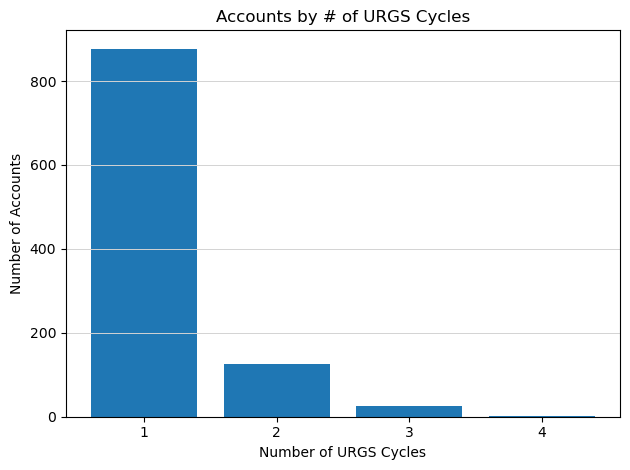

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load & rename
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Sort by account & date
df.sort_values(['account', 'application_date'], inplace=True)

# 3. Assign cycle_id and tag application_type
records = []
for acct, grp in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0
    for _, row in grp.iterrows():
        amt = row['application_amount']
        dt  = row['application_date']
        if cycle_sum == 0:
            cycle_id += 1
            cycle_sum = amt
            cycle_start = dt
            app_type = 'initial application'
        else:
            within_2y    = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed = (cycle_sum + amt) > 650
            if within_2y and not would_exceed:
                app_type = 'top up'
                cycle_sum += amt
            else:
                cycle_id += 1
                cycle_sum = amt
                cycle_start = dt
                app_type = 'initial application'
        records.append({
            'account': acct,
            'cycle_id': cycle_id,
            'application_amount': amt,
            'application_date': dt,
            'application_type': app_type
        })

cycle_df = pd.DataFrame(records)

# 4. Exclude accounts with any cycle > $650
cycle_sums = (
    cycle_df
    .groupby(['account','cycle_id'])['application_amount']
    .sum()
    .reset_index(name='cycle_total')
)
bad_accounts = cycle_sums.loc[cycle_sums['cycle_total'] > 650, 'account'].unique()
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 5. Count cycles per account
cycles_per_account = clean_cycle_df.groupby('account')['cycle_id'].nunique()
counts = cycles_per_account.value_counts().sort_index()

# 6. Plot distribution
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel('Number of URGS Cycles')
plt.ylabel('Number of Accounts')
plt.title('Accounts by # of URGS Cycles')
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.7)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [13]:
# 1. Count how many cycles each account has
cycles_per_account = clean_cycle_df.groupby('account')['cycle_id'].nunique()

# 2. Tally how many accounts have 1 cycle, 2 cycles, etc.
counts = cycles_per_account.value_counts().sort_index()

# 3. Compute total accounts
total_accounts = counts.sum()

# 4. Build the list of (number_of_cycles, number_of_accounts, proportion)
summary_list = [
    (int(cycles), int(count), count/total_accounts)
    for cycles, count in counts.items()
]

# 5. Append the totals row
summary_list.append(("Total", int(total_accounts), 1.0))

# 6. Inspect
for row in summary_list:
    print(row)


(1, 877, 0.8514563106796117)
(2, 126, 0.12233009708737864)
(3, 25, 0.024271844660194174)
(4, 2, 0.001941747572815534)
('Total', 1030, 1.0)


In [17]:
import pandas as pd

# 1. Load the PortProperty data
porg_path = r"C:\Users\andrew.dilley\development\URGS\PorgProperty.csv"
porg_df = pd.read_csv(porg_path, parse_dates=['date_disconnected'])

# 2. Filter for roles O or T and where date_disconnected is null
filtered_porgs = porg_df[
    porg_df['pk_porg_prop_role'].isin(['O', 'T']) &
    porg_df['date_disconnected'].isna()
]

# 3. Peek at the result
print(f"Total records matching: {len(filtered_porgs)}")
print(filtered_porgs.head())


Total records matching: 81381
   pk_porg  pk_property     pk pk_porg_prop_role  fk_account pension_flag  \
0      102         4503   4377                 O  10004402.0            N   
1      102        13662  13511                 O  10013561.0            N   
2      102        16585  16427                 O  10016484.0            N   
3      113          113      5                 O  10000012.0            N   
4      115        43998  87075                 O  30041656.0            N   

   pension_rate life_support_flag prime_debtor_flag date_connected  ...  \
0           NaN                 N                 Y        00:00.0  ...   
1           NaN                 N                 Y        00:00.0  ...   
2           NaN                 N                 Y        00:00.0  ...   
3           0.0                 N                 Y        00:00.0  ...   
4           NaN                 N                 N        00:00.0  ...   

  print_invoice_flag own_occupy_flag               rowid

C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\128799365.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


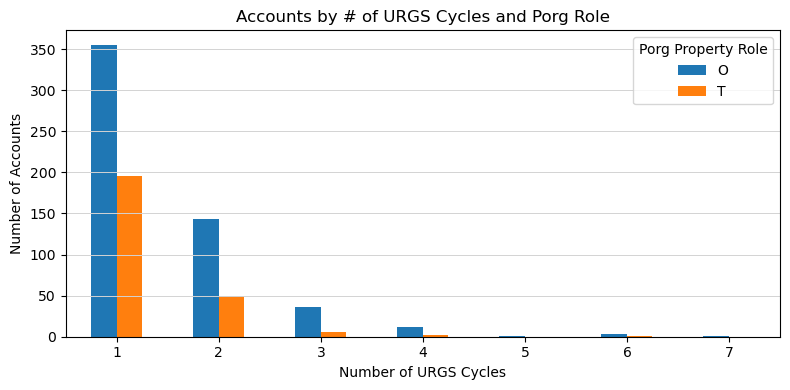

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load & rename URGS_account data
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Load & filter PorgProperty data
porg_path = r"C:\Users\andrew.dilley\development\URGS\PorgProperty.csv"
porg_df = pd.read_csv(porg_path, parse_dates=['date_disconnected'])
porg_df = porg_df[
    porg_df['pk_porg_prop_role'].isin(['O', 'T']) &
    porg_df['date_disconnected'].isna()
]

# 3. Merge porg_prop_role into df
df = df.merge(
    porg_df[['fk_account', 'pk_porg_prop_role']],
    left_on='account', right_on='fk_account',
    how='left'
).drop(columns=['fk_account'])
df.rename(columns={'pk_porg_prop_role': 'porg_prop_role'}, inplace=True)

# 4. Sort by account & date
df.sort_values(['account', 'application_date'], inplace=True)

# 5. Build cycle_df with cycle_id and role
records = []
for acct, grp in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0
    for _, row in grp.iterrows():
        amt   = row['application_amount']
        dt    = row['application_date']
        role  = row['porg_prop_role']
        if cycle_sum == 0:
            cycle_id   += 1
            cycle_sum   = amt
            cycle_start = dt
            app_type    = 'initial application'
        else:
            within_2y    = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed = (cycle_sum + amt) > 650
            if within_2y and not would_exceed:
                app_type  = 'top up'
                cycle_sum += amt
            else:
                cycle_id   += 1
                cycle_sum    = amt
                cycle_start  = dt
                app_type     = 'initial application'
        records.append({
            'account': acct,
            'cycle_id': cycle_id,
            'application_amount': amt,
            'application_date': dt,
            'application_type': app_type,
            'porg_prop_role': role
        })

cycle_df = pd.DataFrame(records)

# 6. Exclude accounts with any cycle > $650
cycle_sums = (
    cycle_df
    .groupby(['account','cycle_id'])['application_amount']
    .sum()
    .reset_index(name='cycle_total')
)
bad_accounts = cycle_sums.loc[cycle_sums['cycle_total'] > 650, 'account'].unique()
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 7. Compute cycles_per_account with role
cycles_per_account = (
    clean_cycle_df
    .groupby(['account','porg_prop_role'])['cycle_id']
    .nunique()
    .reset_index(name='n_cycles')
)

# 8. Pivot to get counts of accounts by (#cycles × role)
counts_role = cycles_per_account.pivot_table(
    index='n_cycles',
    columns='porg_prop_role',
    values='account',
    aggfunc='count',
    fill_value=0
)

# 9. Plot grouped bar chart with light grey horizontal grid
ax = counts_role.plot(kind='bar', figsize=(8,4))
ax.set_xlabel('Number of URGS Cycles')
ax.set_ylabel('Number of Accounts')
ax.set_title('Accounts by # of URGS Cycles and Porg Role')
ax.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.7)
plt.xticks(rotation=0)
plt.legend(title='Porg Property Role')
plt.tight_layout()
plt.show()


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\4227621609.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


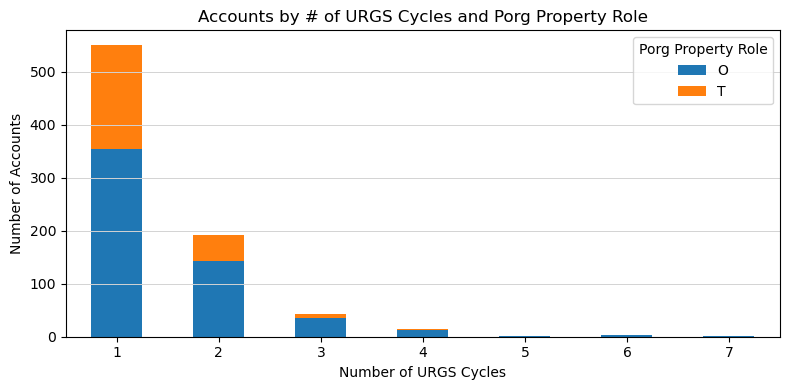

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load & rename URGS_account data
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Load & filter PorgProperty data
porg_path = r"C:\Users\andrew.dilley\development\URGS\PorgProperty.csv"
porg_df = pd.read_csv(porg_path, parse_dates=['date_disconnected'])
# porg_df = porg_df[
#     porg_df['pk_porg_prop_role'].isin(['O', 'T']) &
#     porg_df['date_disconnected'].isna()
# ]

porg_df = porg_df[
    porg_df['pk_porg_prop_role'].isin(['O', 'T'])
]



# 3. Merge porg_prop_role into df
df = df.merge(
    porg_df[['fk_account', 'pk_porg_prop_role']],
    left_on='account',
    right_on='fk_account',
    how='left'
).drop(columns=['fk_account'])
df.rename(columns={'pk_porg_prop_role': 'porg_prop_role'}, inplace=True)

# 4. Sort by account & date
df.sort_values(['account', 'application_date'], inplace=True)

# 5. Build cycle_df with cycle_id, application_type & role
records = []
for acct, grp in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0
    for _, row in grp.iterrows():
        amt  = row['application_amount']
        dt   = row['application_date']
        role = row['porg_prop_role']
        # Determine if new cycle
        if cycle_sum == 0:
            cycle_id += 1
            cycle_sum   = amt
            cycle_start = dt
            app_type    = 'initial application'
        else:
            within_2y    = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed = (cycle_sum + amt) > 650
            if within_2y and not would_exceed:
                app_type  = 'top up'
                cycle_sum += amt
            else:
                cycle_id   += 1
                cycle_sum    = amt
                cycle_start  = dt
                app_type     = 'initial application'
        records.append({
            'account': acct,
            'cycle_id': cycle_id,
            'application_amount': amt,
            'application_date': dt,
            'application_type': app_type,
            'porg_prop_role': role
        })

cycle_df = pd.DataFrame(records)

# 6. Exclude accounts with any cycle > $650
cycle_sums = (
    cycle_df
    .groupby(['account', 'cycle_id'])['application_amount']
    .sum()
    .reset_index(name='cycle_total')
)
bad_accounts = cycle_sums.loc[cycle_sums['cycle_total'] > 650, 'account'].unique()
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 7. Count cycles per account by role
cycles_per_account = (
    clean_cycle_df
    .groupby(['account', 'porg_prop_role'])['cycle_id']
    .nunique()
    .reset_index(name='n_cycles')
)

# 8. Pivot to get counts of accounts by (#cycles × role)
counts_role = cycles_per_account.pivot_table(
    index='n_cycles',
    columns='porg_prop_role',
    values='account',
    aggfunc='count',
    fill_value=0
)

# 9. Plot stacked bar chart with light grey horizontal grid
ax = counts_role.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 4)
)
ax.set_xlabel('Number of URGS Cycles')
ax.set_ylabel('Number of Accounts')
ax.set_title('Accounts by # of URGS Cycles and Porg Property Role')
ax.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.7)
plt.xticks(rotation=0)
plt.legend(title='Porg Property Role')
plt.tight_layout()
plt.show()


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\784511811.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


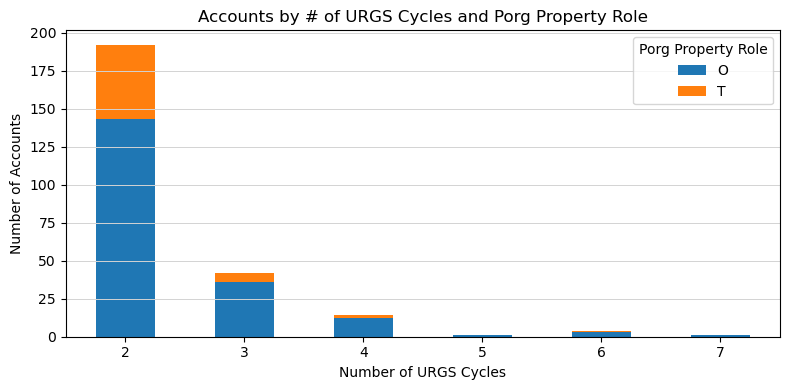

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load & rename URGS_account data
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Load & filter PorgProperty data
porg_path = r"C:\Users\andrew.dilley\development\URGS\PorgProperty.csv"
porg_df = pd.read_csv(porg_path, parse_dates=['date_disconnected'])
porg_df = porg_df[
    porg_df['pk_porg_prop_role'].isin(['O', 'T']) &
    porg_df['date_disconnected'].isna()
]

# 3. Merge porg_prop_role into df
df = df.merge(
    porg_df[['fk_account', 'pk_porg_prop_role']],
    left_on='account', right_on='fk_account',
    how='left'
).drop(columns=['fk_account'])
df.rename(columns={'pk_porg_prop_role': 'porg_prop_role'}, inplace=True)

# 4. Sort by account & date
df.sort_values(['account', 'application_date'], inplace=True)

# 5. Build cycle_df with cycle_id, application_type & role
records = []
for acct, grp in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0
    for _, row in grp.iterrows():
        amt  = row['application_amount']
        dt   = row['application_date']
        role = row['porg_prop_role']
        if cycle_sum == 0:
            cycle_id += 1
            cycle_sum   = amt
            cycle_start = dt
            app_type    = 'initial application'
        else:
            within_2y    = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed = (cycle_sum + amt) > 650
            if within_2y and not would_exceed:
                app_type  = 'top up'
                cycle_sum += amt
            else:
                cycle_id   += 1
                cycle_sum    = amt
                cycle_start  = dt
                app_type     = 'initial application'
        records.append({
            'account': acct,
            'cycle_id': cycle_id,
            'application_amount': amt,
            'application_date': dt,
            'application_type': app_type,
            'porg_prop_role': role
        })

cycle_df = pd.DataFrame(records)

# 6. Exclude accounts with any cycle > $650
cycle_sums = (
    cycle_df
    .groupby(['account','cycle_id'])['application_amount']
    .sum()
    .reset_index(name='cycle_total')
)
bad_accounts = cycle_sums.loc[cycle_sums['cycle_total'] > 650, 'account'].unique()
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 7. Count cycles per account by role
cycles_per_account = (
    clean_cycle_df
    .groupby(['account','porg_prop_role'])['cycle_id']
    .nunique()
    .reset_index(name='n_cycles')
)

# 8. Pivot to get counts of accounts by (#cycles × role)
counts_role = cycles_per_account.pivot_table(
    index='n_cycles',
    columns='porg_prop_role',
    values='account',
    aggfunc='count',
    fill_value=0
)

# 9. Drop the n_cycles = 1 bar
counts_role = counts_role.loc[counts_role.index != 1]

# 10. Plot stacked bar chart with light grey horizontal grid
ax = counts_role.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 4)
)
ax.set_xlabel('Number of URGS Cycles')
ax.set_ylabel('Number of Accounts')
ax.set_title('Accounts by # of URGS Cycles and Porg Property Role')
ax.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.7)
plt.xticks(rotation=0)
plt.legend(title='Porg Property Role')
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# 1. Load & rename URGS_account data
csv_path = r"C:\Users\andrew.dilley\development\URGS\URGS_account.csv"
df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])
df.rename(columns={
    'pk_account': 'account',
    'amount': 'application_amount',
    'evt_datetime': 'application_date'
}, inplace=True)

# 2. Load & filter PorgProperty data
porg_path = r"C:\Users\andrew.dilley\development\URGS\PorgProperty.csv"
porg_df = pd.read_csv(porg_path, parse_dates=['date_disconnected'])
porg_df = porg_df[
    porg_df['pk_porg_prop_role'].isin(['O', 'T']) &
    porg_df['date_disconnected'].isna()
]

# 3. Merge porg_prop_role into df
df = df.merge(
    porg_df[['fk_account', 'pk_porg_prop_role']],
    left_on='account',
    right_on='fk_account',
    how='left'
).drop(columns=['fk_account'])
df.rename(columns={'pk_porg_prop_role': 'porg_prop_role'}, inplace=True)

# 4. Sort by account & date
df.sort_values(['account', 'application_date'], inplace=True)

# 5. Build cycle_df
records = []
for acct, grp in df.groupby('account', sort=False):
    cycle_sum = 0
    cycle_start = None
    cycle_id = 0
    for _, row in grp.iterrows():
        amt  = row['application_amount']
        dt   = row['application_date']
        role = row['porg_prop_role']
        if cycle_sum == 0:
            cycle_id   += 1
            cycle_sum    = amt
            cycle_start  = dt
        else:
            within_2y    = (dt - cycle_start) <= pd.Timedelta(days=730)
            would_exceed = (cycle_sum + amt) > 650
            if within_2y and not would_exceed:
                cycle_sum += amt
            else:
                cycle_id   += 1
                cycle_sum    = amt
                cycle_start  = dt
        records.append({
            'account': acct,
            'cycle_id': cycle_id,
            'porg_prop_role': role
        })

cycle_df = pd.DataFrame(records)

# 6. Exclude accounts with any cycle > $650
cycle_sums = (
    cycle_df
    .groupby(['account','cycle_id'])['porg_prop_role']
    .count()  # or sum on amount if included
    .reset_index(name='cycle_total')
)
# (If you have application_amount in cycle_df, sum that instead)
# cycle_sums = cycle_df.groupby(['account','cycle_id'])['application_amount'].sum().reset_index(name='cycle_total')

bad_accounts = cycle_sums.loc[cycle_sums['cycle_total'] > 650, 'account'].unique()
clean_cycle_df = cycle_df[~cycle_df['account'].isin(bad_accounts)].copy()

# 7. Count cycles per account by role
cycles_per_account = (
    clean_cycle_df
    .groupby(['account','porg_prop_role'])['cycle_id']
    .nunique()
    .reset_index(name='n_cycles')
)

# 8. Pivot to get totals
summary_df = cycles_per_account.pivot_table(
    index='n_cycles',
    columns='porg_prop_role',
    values='account',
    aggfunc='count',
    fill_value=0
).reset_index().rename(columns={'O':'total_O','T':'total_T','n_cycles':'number_of_URGS_cycles'})

# 9. Calculate totals and percentage of T
summary_df['total_accounts'] = summary_df['total_O'] + summary_df['total_T']
summary_df['percentage_of_T'] = summary_df['total_T'] / summary_df['total_accounts']

# 10. Show the result
print(summary_df[['number_of_URGS_cycles','total_accounts','total_O','total_T','percentage_of_T']])


C:\Users\andrew.dilley\AppData\Local\Temp\ipykernel_31112\520709216.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(csv_path, parse_dates=['evt_datetime'])


porg_prop_role  number_of_URGS_cycles  total_accounts  total_O  total_T  \
0                                   1             554      358      196   
1                                   2             192      143       49   
2                                   3              43       36        7   
3                                   4              15       13        2   
4                                   5               3        3        0   
5                                   6               4        3        1   
6                                   7               1        1        0   

porg_prop_role  percentage_of_T  
0                      0.353791  
1                      0.255208  
2                      0.162791  
3                      0.133333  
4                      0.000000  
5                      0.250000  
6                      0.000000  
